In [ ]:
import torch 
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import output

%load_ext tensorboard

In [ ]:
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def class_preds_fig(N, x, y, out):
    fig = plt.figure(figsize=(6, 24))
    for idx in np.arange(N):
        ax = fig.add_subplot(N, 1, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(x[idx], one_channel=True)
        ax.set_title("{0}, {1:.2f}%\n".format(y[idx], torch.exp(out[idx][y[idx]]) * 100.0),
                color=("green" if torch.argmax(out[idx])==y[idx] else "red"),
                y=0.85, fontsize=18)
    return fig

In [ ]:
class ConvNet(nn.Module):

    def __init__(self, input_shape, output_shape, output_act, name, seed=43):
        super(ConvNet, self).__init__()
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        self.layer1 = nn.Sequential(
            nn.Conv2d(input_shape, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, output_shape)

        self.output_act = output_act

        self.writer = SummaryWriter('runs/{}'.format(name))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        if self.output_act:
            out = self.output_act(out)
        return out

    def test(self, epoch, criterion, testdata):
        mean_loss = 0.0
        accuracy = 0.0
        total = 0.0

        with torch.no_grad():
            for x, y in testdata:
                x, y = x.to(device), y.to(device)
                out = self(x)
                loss = criterion(out, y)
                total += y.size(0)
                mean_loss += loss.item() * y.size(0)
                accuracy += (torch.argmax(out, dim=1) == y).sum()

        self.writer.add_scalar('test loss', mean_loss/total, epoch)
        self.writer.add_scalar('test acc', accuracy/total, epoch)

        return mean_loss/total, accuracy/total

    def learn(self, criterion, epochs, traindata, testdata, 
            r_lambda=0, optimizer=None, lr_schedulers=None, 
            nesterov=False, eta=0.001, verbos=1):

        dataiter = iter(traindata)
        images, _ = dataiter.next()
        self.writer.add_graph(self, images.to(device))

        if optimizer:
            optimizer = optimizer[0](self.parameters(), lr=eta,
                                     weight_decay=r_lambda, **optimizer[1])
        else:
            optimizer = torch.optim.SGD(self.parameters(), lr=eta,
                                        momentum=0.9, weight_decay=r_lambda,
                                        nesterov=nesterov)

        l_bar = '{percentage:3.0f}%|'
        r_bar = '|{n_fmt}/{total_fmt}[{elapsed}<{remaining},{rate_fmt}{postfix}]'
        t = tqdm(range(epochs), disable=(not verbos), position=0, leave=True,
                 bar_format= l_bar+ '{bar}' + r_bar +' {desc}')
        fig_r = 0
        test_loss, test_acc = 0, 0
        train_loss, train_acc = 0, 0
        for i in t:
            mean_loss = 0.0
            mean_accuracy = 0.0
            total = 0.0

            for step, (x, y) in enumerate(traindata):
                x, y = x.to(device), y.to(device)
                out = self(x)
                loss = criterion(out, y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                accuracy = (torch.argmax(out, dim=1) == y).sum()

                if verbos == 1:
                    if i>0:
                        t.set_description("train loss:{:.8f} train acc:{:.2f} test loss:{:.8f} test acc:{:.2f}" 
                                    .format(loss.item(), 
                                            accuracy/(y.size(0)*1.),
                                            test_loss,
                                            test_acc))
                    else:
                        t.set_description("train loss:{} train acc:{:.2f}"
                                    .format(loss.item(),
                                            accuracy/(y.size(0)*1.)))
                    t.refresh()

                total += y.size(0)
                mean_loss += loss.item() * y.size(0)
                mean_accuracy += accuracy

                fig_r += 1
                if fig_r % 200 == 0:
                    self.writer.add_figure('Class Prediction Figure',
                                        class_preds_fig(8, x, y, out),
                                        global_step=i)
                    fig_r = 0

            self.writer.add_scalar('train loss', mean_loss/total, i)
            self.writer.add_scalar('train acc', mean_accuracy/total, i)
            
            train_loss, train_acc = mean_loss/total, mean_accuracy/total
            test_loss, test_acc = self.test(i, criterion, testdata)

            if verbos == 1:
                t.set_description("train loss:{:.8f} train acc:{:.2f} test loss:{:.8f} test acc:{:.2f}" 
                            .format(train_loss, train_acc, test_loss, test_acc))
                t.refresh()

        self.writer.close()

    def weight_init(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(m.bias)

    def reset(self):
        self.apply(self.weight_init)

In [ ]:
RMSprop = (torch.optim.RMSprop, {'alpha':0.99, 'eps':1e-08,
                                 'momentum':0, 'centered':False})
Adam = (torch.optim.Adam, {'betas':(0.9, 0.999), 'eps':1e-08,
                           'amsgrad':False})
Adadelta = (torch.optim.Adadelta, {'rho':0.9, 'eps':1e-06})
Adagrad = (torch.optim.Adagrad, {'lr_decay':0, 'initial_accumulator_value':0,
                                'eps':1e-10})

In [ ]:
epochs = 10
batch_size = 128

transform = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5), (0.5))])

traindata = datasets.MNIST(root='../../data/',
                            train=True, 
                            transform=transform,
                            download=True)
testdata = datasets.MNIST(root='../../data/',
                            train=False, 
                            transform=transform)

traindata = torch.utils.data.DataLoader(dataset=traindata, 
                                    batch_size=batch_size, 
                                    shuffle=True)
testdata = torch.utils.data.DataLoader(dataset=testdata,
                                    shuffle=False)

mynet = ConvNet(1, 10, nn.LogSoftmax(dim=1), 'BS_128').to(device)
mynet.reset()
mynet.learn(nn.NLLLoss(), epochs, traindata, testdata, optimizer=RMSprop,
            r_lambda=1e-4, eta=0.001)

100%|██████████|10/10[05:04<00:00,30.42s/it] train loss:0.01210315 train acc:1.00 test loss:0.02295778 test acc:0.99: 


In [ ]:
%tensorboard --logdir runs

In [ ]:
def conv_shape(input_size, padding, dilation, kernel, stride):
    return int((input_size + (2*padding) - dilation*(kernel-1) - 1)/stride+1)

In [ ]:
conv_shape(14, 0, 1, 2, 2)

7

In [ ]:
filters, layers = [], []
for i in mynet.children():
    if isinstance(i, nn.Sequential):
        for j in i.children():
            if isinstance(j, nn.Conv2d):
                filters.append(j.weight)
            layers.append(j)

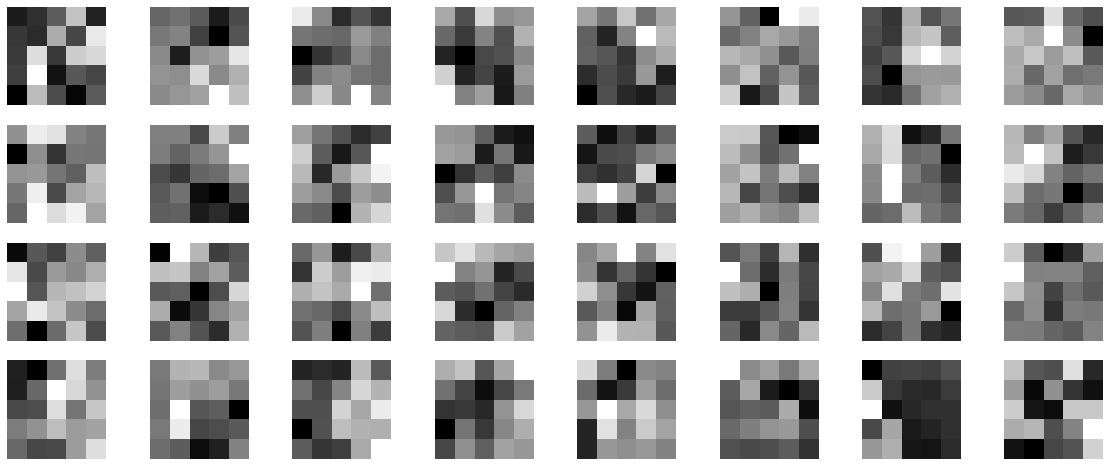

In [ ]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(filters[1]):
    plt.subplot(8, 8, i+1)
    plt.imshow(filter[0, :, :].detach().cpu(), cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
dataiter = iter(testdata)

torch.Size([16, 28, 28])


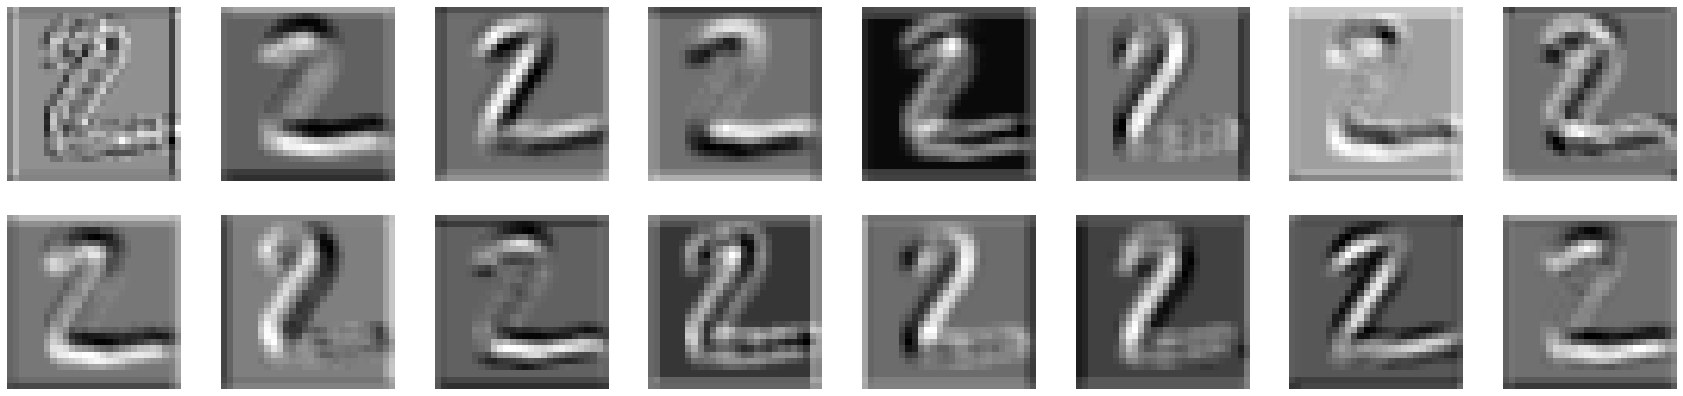

torch.Size([16, 28, 28])


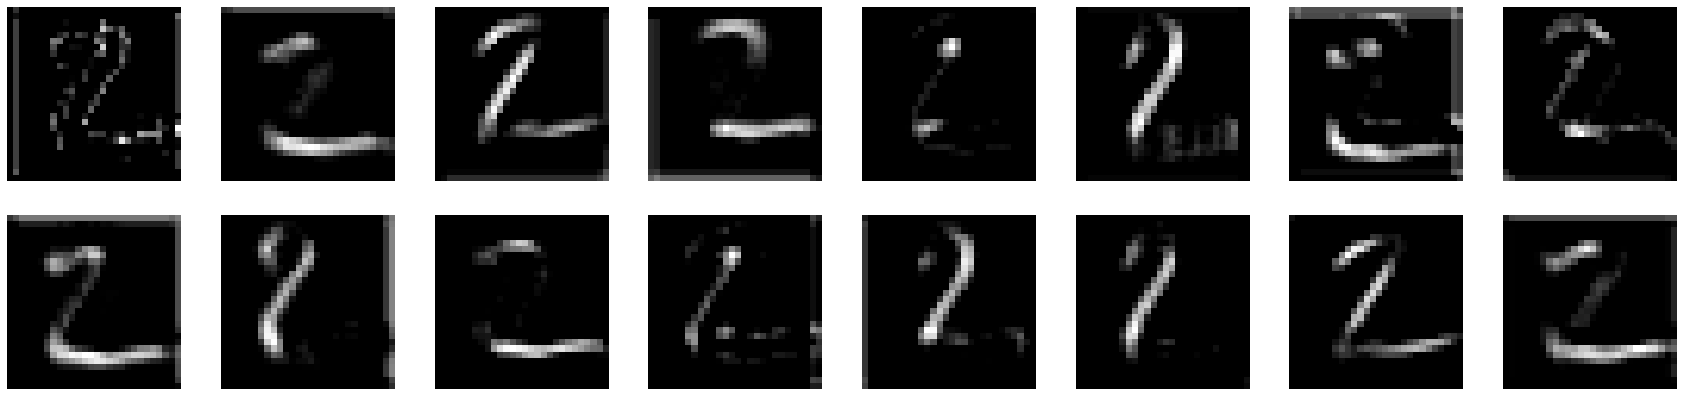

torch.Size([16, 14, 14])


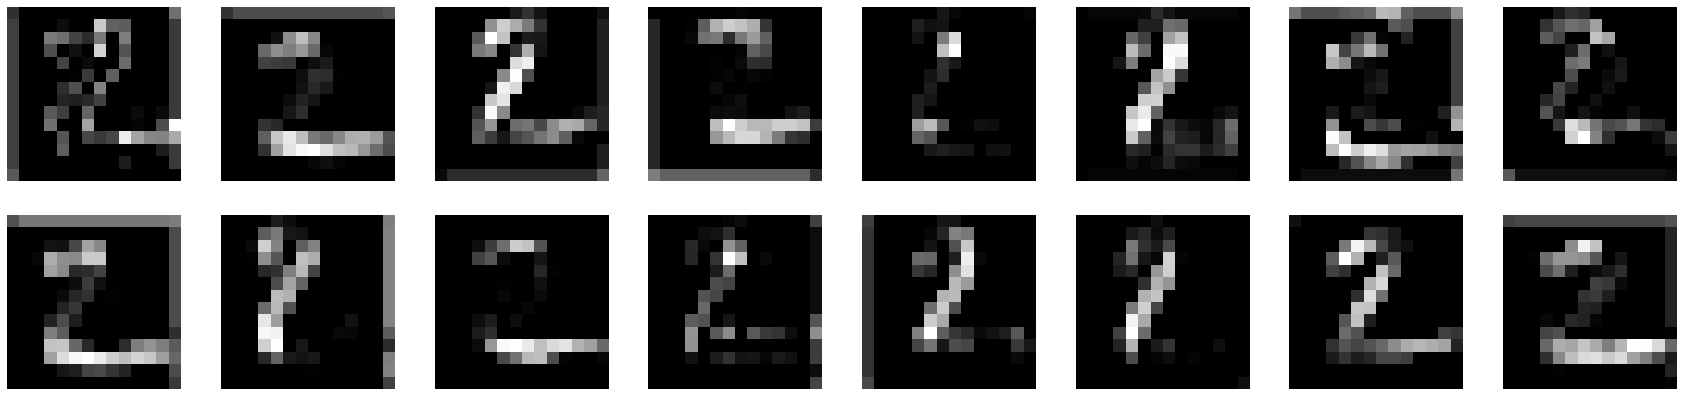

torch.Size([32, 14, 14])


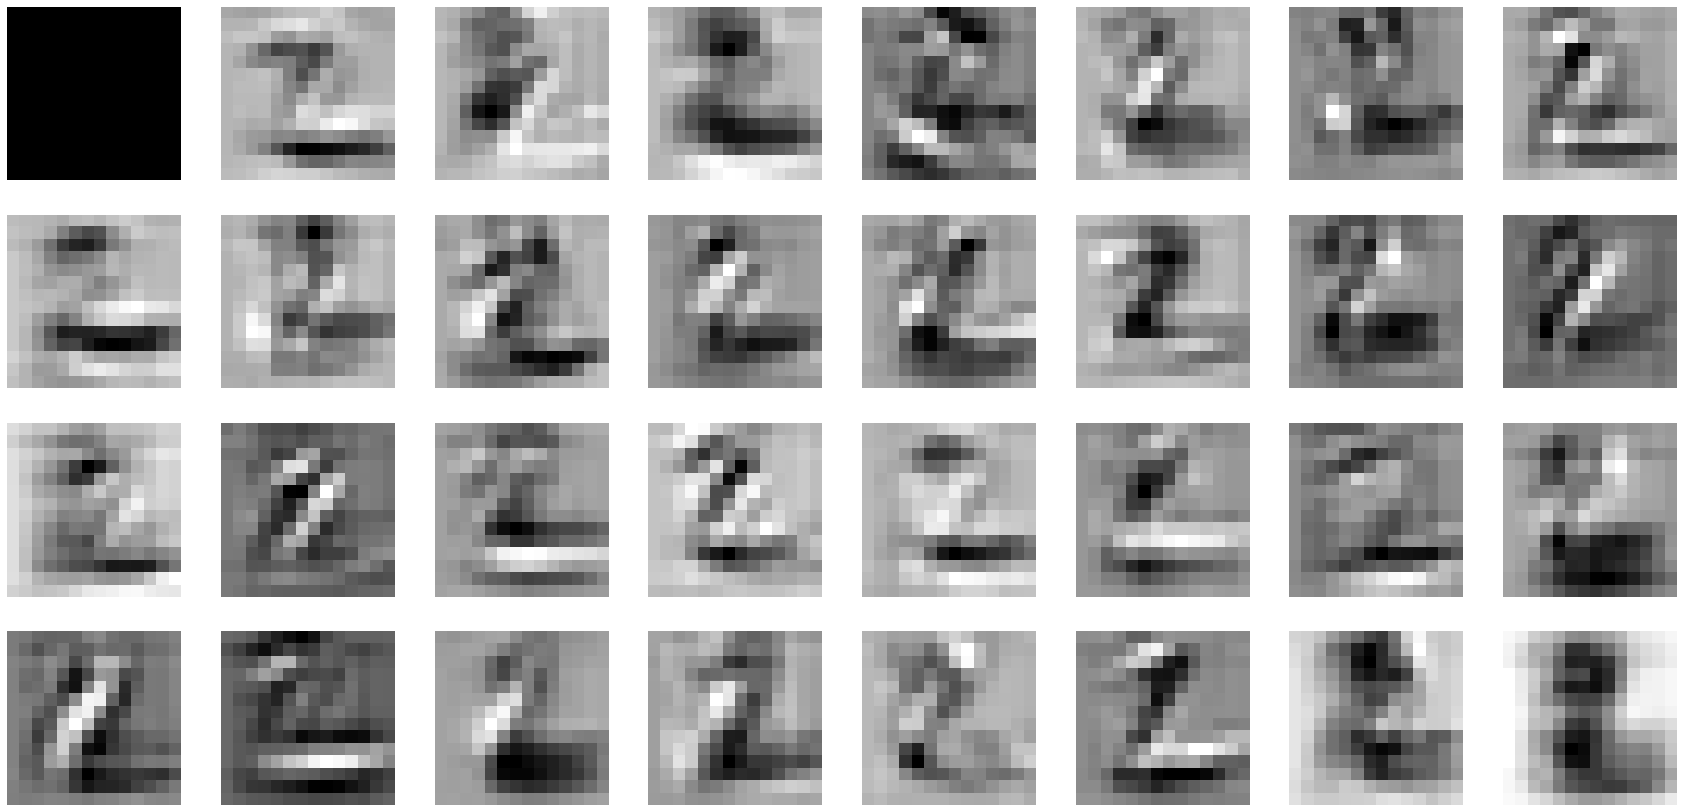

torch.Size([32, 14, 14])


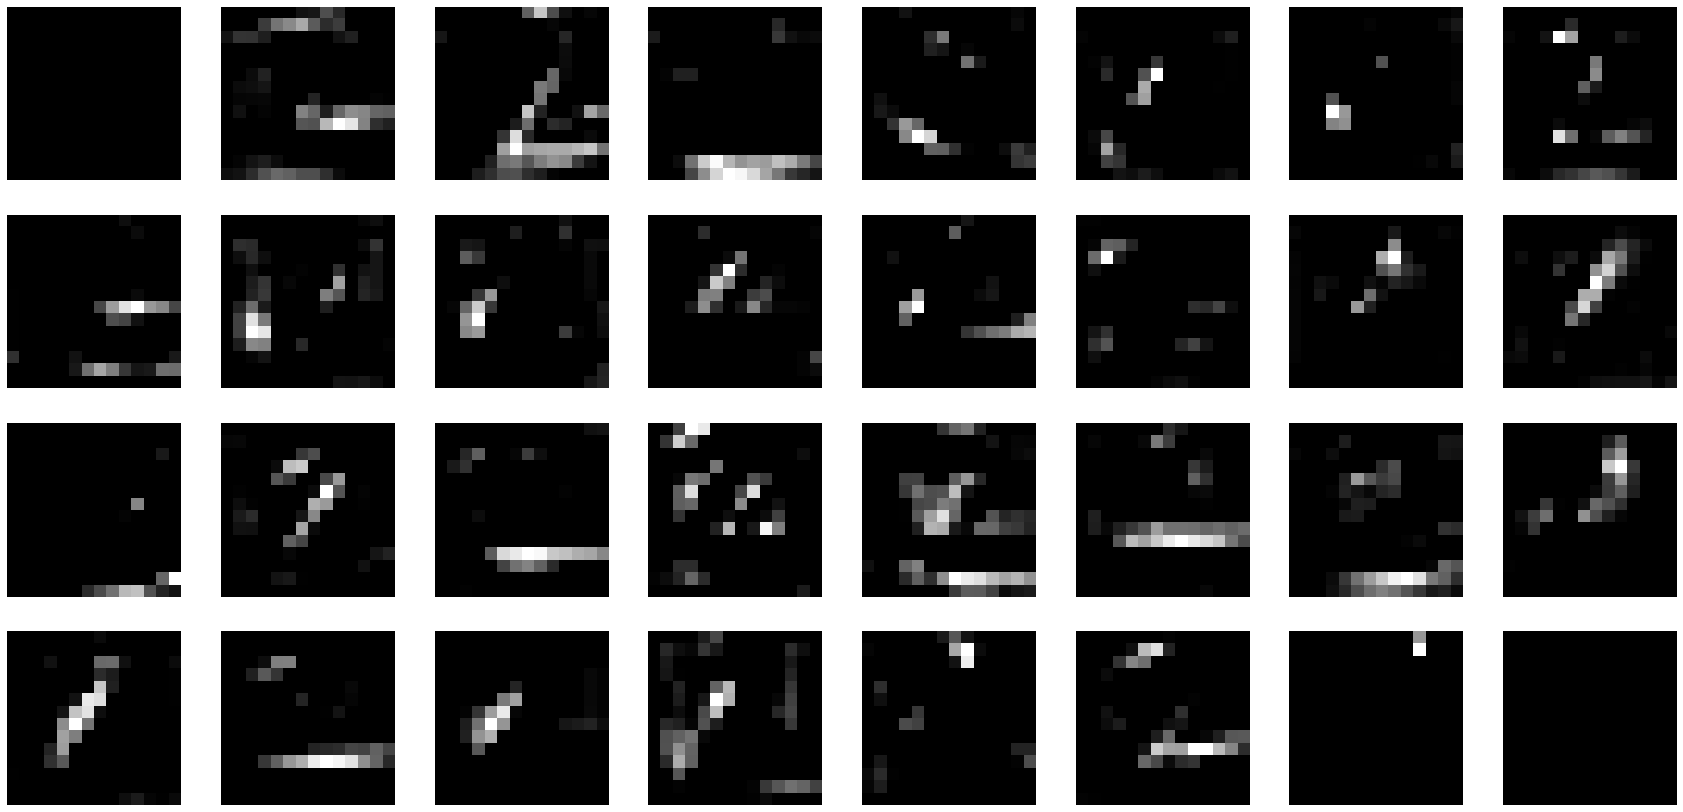

torch.Size([32, 7, 7])


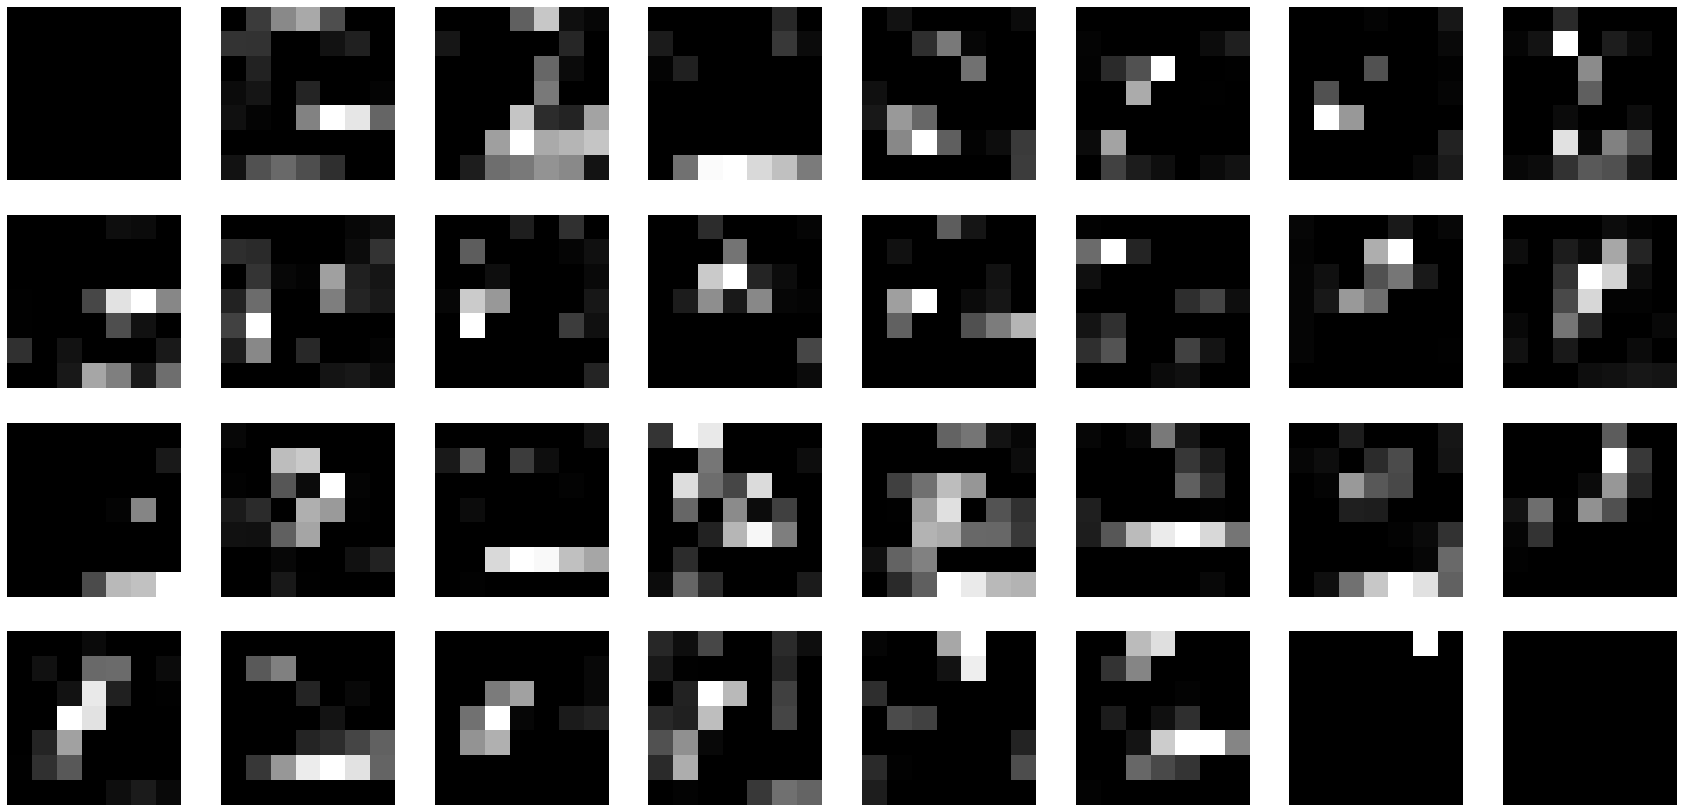

In [ ]:
img, _ = dataiter.next()
results = [layers[0](img.to(device))]

for i in range(1, len(layers)):
    results.append(layers[i](results[-1]))
outputs = results

for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu(), cmap='gray')
        plt.axis("off")
    plt.show()